# The function for calling MRAPSS() from MRAPSS package

In [3]:
run_APSS_func <- function(clumped=NULL,
                          exposure=NULL,
                          outcome=NULL,
                          C = diag(2),
                          Omega = matrix(0, 2, 2),
                          IV.Threshold = 5e-08, # IV selection threshold
                          Threshold = 5e-08,    # threshold for correcting for selection bias
                          Cor.SelectionBias=T){
  
 
  res=NULL
  
  for(i in 1:length(Threshold)){
    
    start = proc.time()
    if(!is.null(clumped)){
      
      test = subset(clumped, pval.exp <= IV.Threshold[i])
      if(nrow(test) < 4 ) next
      test$Threshold = Threshold[i]
      cat("IV selection threshold:", IV.Threshold[i] ,"\n")
      
      
      MRres = try(MRAPSS::MRAPSS(test,
                                 exposure=exposure,
                                 outcome=outcome,
                                 C= C,
                                 Omega= Omega,
                                 Cor.SelectionBias = Cor.SelectionBias))
      print(proc.time()-start)
      
      if(inherits(MRres, 'try-error')) {
        MRres=NULL
      }
    }
    
    
    res0 = data.frame(exposure = MRres$exposure,
                      outcome = MRres$outcome,
                      nSNP = nrow(MRres$MRdat),
                      pi0 = MRres$pi0,
                      nvalid = nrow(MRres$MRdat)*MRres$pi0,
                      sigma.sq= MRres$sigma.sq,
                      tau.sq= MRres$tau.sq,
                      beta = MRres$beta,
                      se = MRres$beta.se,
                      pval= MRres$pvalue,
                      method = MRres$method,
                      Threshold = Threshold[i],
                      IVstrength = MRres$IVsignal.sum
    )
    
    if(nrow(res0)!=0){
      res0$IV.Threshold = IV.Threshold[i]
    }
    
    res = rbind(res, res0)
    
  }
  
  return(res)
  
}



# Run MR-APSS at IV threshold 5e-05 (default)

In [4]:
# All the results will be saved to the file "NC_MRAPSS.MRres"
start = proc.time()
ts1 = c("AD", "ASD", "Daytime_Sleepiness", "Height_UKB",  "Intelligence", "RA",      
        "T2D", "Alcohol", "BMI", "Depression", "IBD", "MDD", "SCZ", "Angina", 
        "CAD", "HBP", "Income", "NEB", "Smoking", "Urate", "Anorexia", 
        "CD", "Height_GIANT", "Insomnia", "Neuroticism", "SWB")

ts2 = c("Hair_Light_Brown", "Hair_Dark_Brown",  "Hair_Black",    "Hair_Blonde",  "Tanning")

IV.Threshold = 5e-05

for( exposure in ts1){
  
  for( outcome in ts2){
    
    cat("Pair: ", exposure,"~", outcome,"\n")
    # read in GWAS summary data for IVs
    clumped = try(read.table(paste0("./MRdat/", exposure,"~",outcome), header = T))
    
    # read in background parameters Omega and C
    C = try(as.matrix(read.table(paste0("./pairs_bg_paras/",exposure, "~", outcome,"_C"),
                                 header = F)))
    
    C = matrix(C[nrow(C), ], 2,2)
    
    Omega = try(as.matrix(read.table(paste0("./pairs_bg_paras/", exposure, "~", outcome,"_Omega"),
                                     header = F)))
      
    Omega = matrix(Omega[nrow(Omega), ], 2, 2)
    
    if(inherits(clumped , 'try-error')) clumped = NULL
    if(inherits(C, 'try-error')) next
    if(inherits(Omega, 'try-error')) next
    if(nrow(clumped) < 4 ) next
    
    # The p-value threshold for selection bias correction
    Threshold =  ifelse(IV.Threshold==5e-05, unique(clumped$Threshold), IV.Threshold)
    
    # MR-APSS
    cat("Run MR-APSS ... \n")
    res = run_APSS_func(clumped = clumped,
                        exposure = exposure,
                        outcome = outcome,
                        C = C,
                        Omega=Omega,
                        IV.Threshold = IV.Threshold,
                        Threshold = Threshold,
                        Cor.SelectionBias = T)
    
    # MR-APSS(Omega=0)
    cat("Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... \n")
    res_Omega0 = run_APSS_func(clumped = clumped,
                               exposure = exposure,
                               outcome = outcome,
                               C = C,
                               Omega=matrix(0, 2, 2),
                               IV.Threshold = IV.Threshold,
                               Threshold = Threshold,
                               Cor.SelectionBias = T)
    res_Omega0$method = "MR-APSS(Omega=0)"
     
     # MR-APSS(C=I)
     cat("Run MR-APSS (C = I), i.e. MR-APSS not accounting for sample structure ... \n")
     res_CI = run_APSS_func(clumped = clumped,
                                exposure = exposure,
                                outcome = outcome,
                                C = diag(2),
                                Omega = Omega,
                                IV.Threshold = IV.Threshold,
                                Threshold = Threshold,
                                Cor.SelectionBias = T)
     res_CI$method = "MR-APSS(C=I)"
     
     # MR-APSS not accounting for selection bias
     cat("Run MR-APSS not accounting for selection bias ... \n")
     res_selec0 = run_APSS_func(clumped = clumped,
                            exposure = exposure,
                            outcome = outcome,
                            C = C,
                            Omega = Omega,
                            IV.Threshold = IV.Threshold,
                            Threshold = Threshold,
                            Cor.SelectionBias = F)
     res_selec0$method = "MR-APSS(Cor.SelectionBia=F)"
     
     # saving resuts
     write.table(res, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_Omega0, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_CI, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_selec0, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
}
  
}

print(proc.time()-start)


Pair:  AD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0187 , p-value =  7.1987e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.08942 . 
***********************************************************
   user  system elapsed 
  1.117   0.748   0.932 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0058 , beta.se =  0.0175 , p-value =  7.4077e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.68984 . 
***********************************************************
   user  system elapsed 
  1.291   0.742   1.017 
Run MR-APSS (C = I), i.e. MR-APSS not accounting for sample st

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.001 , beta.se =  0.0116 , p-value =  9.2870e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 28.090  17.906  22.998 
Pair:  AD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0 , beta.se =  0.0044 , p-value =  9.9758e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.04725 . 
***********************************************************
   user  system elapsed 
  0.918   0.590   0.754 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resu

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0027 , beta.se =  0.0133 , p-value =  8.3785e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.308   0.171   0.239 
Pair:  AD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.014 , beta.se =  0.0207 , p-value =  4.9808e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.15173 . 
***********************************************************
   user  system elapsed 
  1.382   0.911   1.147 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.0089 , beta.se =  0.0132 , p-value =  4.9785e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 17.884  11.211  14.547 
Pair:  AD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0181 , beta.se =  0.0194 , p-value =  3.5122e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  16.80597 . 
***********************************************************
   user  system elapsed 
  1.368   0.767   1.067 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  A

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0018 , beta.se =  0.0124 , p-value =  8.8542e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.281   0.193   0.237 
Pair:  AD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0218 , beta.se =  0.0258 , p-value =  3.9880e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.07372 . 
***********************************************************
   user  system elapsed 
  7.549   4.766   6.160 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0231 , beta.se =  0.015 , p-value =  1.2469e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 45.103  28.252  36.688 
Pair:  ASD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0171 , beta.se =  0.036 , p-value =  6.3410e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.99107 . 
***********************************************************
   user  system elapsed 
 16.556  10.325  13.441 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0074 , beta.se =  0.0102 , p-value =  4.6922e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  3.062   1.933   2.497 
Pair:  ASD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0117 , beta.se =  0.0492 , p-value =  8.1155e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.93972 . 
***********************************************************
   user  system elapsed 
 26.149  16.585  21.366 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR t

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0029 , beta.se =  0.0127 , p-value =  8.2034e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  0.529   0.323   0.425 
Pair:  ASD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Black : 
MR-APSS: beta =  -0.0164 , beta.se =  0.0417 , p-value =  6.9367e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.99109 . 
***********************************************************
   user  system elapsed 
 22.246  13.789  18.018 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Black : 
MR-APSS: beta =  -0.0031 , beta.se =  0.0115 , p-value =  7.8715e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
 16.714  10.585  13.649 
Pair:  ASD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0223 , beta.se =  0.0411 , p-value =  5.8683e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.97507 . 
***********************************************************
   user  system elapsed 
 15.662   9.974  12.818 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Blonde : 
MR-APSS: beta =  -0.005 , beta.se =  0.011 , p-value =  6.5054e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  0.172   0.132   0.152 
Pair:  ASD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Tanning : 
MR-APSS: beta =  0.7171 , beta.se =  0.4633 , p-value =  1.2170e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  1.016126 . 
***********************************************************
   user  system elapsed 
  10.38    6.70    8.54 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Tanning : 
MR-APSS: beta =  0.0108 , beta.se =  0.0179 , p-value =  5.4499e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  0.990   0.618   0.804 
Pair:  Daytime_Sleepiness ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0709 , beta.se =  0.0516 , p-value =  1.6975e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  69.69107 . 
***********************************************************
   user  system elapsed 
 36.722  23.137  29.969 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0387 , beta.se =  0.0206 , p-value =  6.0403e-02 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  242.9757 . 
***********************************************************
   user  system elapsed 
 60.307  37.413  48.922 
Pair:  Daytime_Sleepiness ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1 , beta.se =  0.0535 , p-value =  6.1889e-02 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  70.09645 . 
***********************************************************
   user  system elapsed 
 10.394   6.551   8.498 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
******************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0565 , beta.se =  0.0234 , p-value =  1.5712e-02 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  241.9758 . 
***********************************************************
   user  system elapsed 
  1.272   0.814   1.043 
Pair:  Daytime_Sleepiness ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0614 , beta.se =  0.0677 , p-value =  3.6449e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  65.20411 . 
***********************************************************
   user  system elapsed 
  7.121   4.489   5.811 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0203 , beta.se =  0.0243 , p-value =  4.0329e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  242.9757 . 
***********************************************************
   user  system elapsed 
 14.652   9.316  11.993 
Pair:  Daytime_Sleepiness ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.06 , beta.se =  0.0688 , p-value =  3.8270e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  62.48233 . 
***********************************************************
   user  system elapsed 
  8.939   5.500   7.232 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*******************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.0314 , beta.se =  0.0238 , p-value =  1.8711e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  242.9757 . 
***********************************************************
   user  system elapsed 
 12.011   7.346   9.701 
Pair:  Daytime_Sleepiness ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0198 , beta.se =  0.0661 , p-value =  7.6425e-01 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  66.92029 . 
***********************************************************
   user  system elapsed 
 41.327  25.783  33.576 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0281 , beta.se =  0.0264 , p-value =  2.8595e-01 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  241.9758 . 
***********************************************************
   user  system elapsed 
  1.221   0.845   1.033 
Pair:  Height_UKB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0057 , beta.se =  0.0092 , p-value =  5.3288e-01 . 
Total NO. of IVs=  2226 , NO. of valid IVs with foreground signals:  388.8473 . 
***********************************************************
   user  system elapsed 
 30.359   6.934  28.251 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0421 , beta.se =  0.0046 , p-value =  1.2792e-19 . 
Total NO. of IVs=  2226 , NO. of valid IVs with foreground signals:  2225.767 . 
***********************************************************
   user  system elapsed 
 79.917  17.327  74.698 
Pair:  Height_UKB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -8e-04 , beta.se =  0.0096 , p-value =  9.2945e-01 . 
Total NO. of IVs=  2224 , NO. of valid IVs with foreground signals:  384.6182 . 
***********************************************************
   user  system elapsed 
 25.694   6.064  23.878 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0366 , beta.se =  0.0056 , p-value =  7.2586e-11 . 
Total NO. of IVs=  2224 , NO. of valid IVs with foreground signals:  2223.766 . 
***********************************************************
   user  system elapsed 
  34.51    7.52   32.30 
Pair:  Height_UKB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.016 , beta.se =  0.011 , p-value =  1.4651e-01 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  392.0548 . 
***********************************************************
   user  system elapsed 
 32.325   7.475  30.219 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.0701 , beta.se =  0.0056 , p-value =  1.4034e-36 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  2226.765 . 
***********************************************************
   user  system elapsed 
 56.313  12.887  52.523 
Pair:  Height_UKB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0117 , beta.se =  0.0102 , p-value =  2.4775e-01 . 
Total NO. of IVs=  2225 , NO. of valid IVs with foreground signals:  395.9658 . 
***********************************************************
   user  system elapsed 
 30.977   7.177  28.743 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0256 , beta.se =  0.005 , p-value =  2.4516e-07 . 
Total NO. of IVs=  2225 , NO. of valid IVs with foreground signals:  2224.768 . 
***********************************************************
   user  system elapsed 
 48.811  11.114  45.548 
Pair:  Height_UKB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0167 , beta.se =  0.0144 , p-value =  2.4796e-01 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  382.7249 . 
***********************************************************
   user  system elapsed 
 34.762   7.757  32.228 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0445 , beta.se =  0.0063 , p-value =  1.6045e-12 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  2226.765 . 
***********************************************************
   user  system elapsed 
 45.685  10.052  42.768 
Pair:  Intelligence ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0797 , beta.se =  0.0252 , p-value =  1.5685e-03 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  69.4331 . 
***********************************************************
   user  system elapsed 
 17.802  10.676  14.716 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.011 , beta.se =  0.0083 , p-value =  1.8533e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  401.9598 . 
***********************************************************
   user  system elapsed 
  2.104   1.126   1.698 
Pair:  Intelligence ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1092 , beta.se =  0.0539 , p-value =  4.2833e-02 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  51.68734 . 
***********************************************************
   user  system elapsed 
 12.922   7.497  10.660 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0525 , beta.se =  0.0106 , p-value =  6.9252e-07 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  400.9599 . 
***********************************************************
   user  system elapsed 
 34.124  20.194  28.520 
Pair:  Intelligence ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0832 , beta.se =  0.0583 , p-value =  1.5341e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  48.11368 . 
***********************************************************
   user  system elapsed 
  9.276   5.356   7.603 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0662 , beta.se =  0.0103 , p-value =  1.5159e-10 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  401.9598 . 
***********************************************************
   user  system elapsed 
 46.814  26.137  38.480 
Pair:  Intelligence ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0033 , beta.se =  0.059 , p-value =  9.5608e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  39.436 . 
***********************************************************
   user  system elapsed 
  8.206   4.905   6.815 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0096 , beta.se =  0.0113 , p-value =  3.9875e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  401.9598 . 
***********************************************************
   user  system elapsed 
  6.892   4.058   5.582 
Pair:  Intelligence ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0561 , beta.se =  0.0365 , p-value =  1.2426e-01 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  67.96917 . 
***********************************************************
   user  system elapsed 
228.960 133.224 189.290 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0747 , beta.se =  0.0113 , p-value =  3.7834e-11 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  400.9599 . 
***********************************************************
   user  system elapsed 
101.095  59.044  84.120 
Pair:  RA ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0237 , p-value =  5.6386e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  74.35472 . 
***********************************************************
   user  system elapsed 
  3.045   1.981   2.512 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0091 , beta.se =  0.0132 , p-value =  4.9245e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  2.234   1.506   1.870 
Pair:  RA ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0259 , beta.se =  0.0212 , p-value =  2.2231e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  81.41212 . 
***********************************************************
   user  system elapsed 
  3.543   2.197   2.870 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0199 , beta.se =  0.0134 , p-value =  1.3625e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  2.478   1.639   2.058 
Pair:  RA ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  0.004 , beta.se =  0.0214 , p-value =  8.5307e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  83.1323 . 
***********************************************************
   user  system elapsed 
  3.232   2.034   2.633 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  0.0034 , beta.se =  0.0138 , p-value =  8.0556e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  1.861   1.236   1.548 
Pair:  RA ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0355 , beta.se =  0.024 , p-value =  1.3951e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  76.51705 . 
***********************************************************
   user  system elapsed 
  3.629   2.221   2.925 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0261 , beta.se =  0.0148 , p-value =  7.7660e-02 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  1.947   1.154   1.550 
Pair:  RA ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  -0.0163 , beta.se =  0.0267 , p-value =  5.4084e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  80.54298 . 
***********************************************************
   user  system elapsed 
  3.752   2.270   3.010 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  -0.013 , beta.se =  0.0161 , p-value =  4.1997e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  2.380   1.512   1.945 
Pair:  T2D ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0033 , beta.se =  0.0144 , p-value =  8.1801e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  196.7693 . 
***********************************************************
   user  system elapsed 
 10.969   4.997   9.594 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  -1e-04 , beta.se =  0.0042 , p-value =  9.8842e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9347 . 
***********************************************************
   user  system elapsed 
  8.224   3.849   7.066 
Pair:  T2D ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0019 , beta.se =  0.0186 , p-value =  9.1673e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  182.5653 . 
***********************************************************
   user  system elapsed 
  9.951   4.523   8.573 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  5e-04 , beta.se =  0.0094 , p-value =  9.5917e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9345 . 
***********************************************************
   user  system elapsed 
  3.030   1.460   2.617 
Pair:  T2D ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0193 , beta.se =  0.017 , p-value =  2.5816e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  194.6297 . 
***********************************************************
   user  system elapsed 
 11.757   5.163  10.083 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0207 , beta.se =  0.0094 , p-value =  2.7529e-02 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9346 . 
***********************************************************
   user  system elapsed 
  7.160   3.246   6.313 
Pair:  T2D ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0198 , p-value =  4.8947e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  178.716 . 
***********************************************************
   user  system elapsed 
 12.341   5.653  10.885 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0095 , p-value =  4.8033e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9345 . 
***********************************************************
   user  system elapsed 
  8.574   3.929   7.384 
Pair:  T2D ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  0.0029 , beta.se =  0.0183 , p-value =  8.7245e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  192.9963 . 
***********************************************************
   user  system elapsed 
 10.545   4.578   9.049 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  1e-04 , beta.se =  0.0047 , p-value =  9.8904e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9346 . 
***********************************************************
   user  system elapsed 
  8.846   4.052   7.703 
Pair:  Alcohol ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0982 , beta.se =  0.0482 , p-value =  4.1722e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  78.92478 . 
***********************************************************
   user  system elapsed 
 10.846   6.887   8.996 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0328 , beta.se =  0.0177 , p-value =  6.4443e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
  9.737   5.996   7.887 
Pair:  Alcohol ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1332 , beta.se =  0.0647 , p-value =  3.9482e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  72.03044 . 
***********************************************************
   user  system elapsed 
 10.604   6.454   8.681 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0549 , beta.se =  0.0211 , p-value =  9.4193e-03 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
  5.399   3.388   4.522 
Pair:  Alcohol ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0426 , beta.se =  0.051 , p-value =  4.0393e-01 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  82.75135 . 
***********************************************************
   user  system elapsed 
 15.812   9.480  13.098 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0319 , beta.se =  0.0192 , p-value =  9.7134e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
 27.015  16.239  21.971 
Pair:  Alcohol ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0666 , beta.se =  0.0569 , p-value =  2.4153e-01 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  73.91564 . 
***********************************************************
   user  system elapsed 
 10.011   6.137   8.302 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0482 , beta.se =  0.0196 , p-value =  1.3949e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
 10.318   5.615   9.071 
Pair:  Alcohol ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0241 , beta.se =  0.0736 , p-value =  7.4346e-01 . 
Total NO. of IVs=  342 , NO. of valid IVs with foreground signals:  70.91884 . 
***********************************************************
   user  system elapsed 
  8.349   4.095   8.236 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test re

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0935 , beta.se =  0.0249 , p-value =  1.7747e-04 . 
Total NO. of IVs=  342 , NO. of valid IVs with foreground signals:  341.9658 . 
***********************************************************
   user  system elapsed 
  7.996   4.750   6.549 
Pair:  BMI ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0213 , beta.se =  0.0218 , p-value =  3.2884e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  197.0567 . 
***********************************************************
   user  system elapsed 
 28.977   8.188  26.457 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  7e-04 , beta.se =  0.0073 , p-value =  9.2138e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 36.152  10.460  34.283 
Pair:  BMI ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0023 , beta.se =  0.026 , p-value =  9.2838e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  186.3865 . 
***********************************************************
   user  system elapsed 
 23.783   6.725  21.701 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0321 , beta.se =  0.0094 , p-value =  6.0706e-04 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 38.288   9.873  36.295 
Pair:  BMI ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.022 , beta.se =  0.0242 , p-value =  3.6311e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  197.963 . 
***********************************************************
   user  system elapsed 
 32.937   9.510  31.322 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.0202 , beta.se =  0.0085 , p-value =  1.7901e-02 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 61.563  16.949  58.490 
Pair:  BMI ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  -0.017 , beta.se =  0.0304 , p-value =  5.7666e-01 . 
Total NO. of IVs=  1300 , NO. of valid IVs with foreground signals:  169.6131 . 
***********************************************************
   user  system elapsed 
 31.980   9.589  29.524 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  0.0064 , beta.se =  0.0083 , p-value =  4.3661e-01 . 
Total NO. of IVs=  1300 , NO. of valid IVs with foreground signals:  1299.87 . 
***********************************************************
   user  system elapsed 
 59.566  17.351  54.508 
Pair:  BMI ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0798 , beta.se =  0.032 , p-value =  1.2714e-02 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  201.1114 . 
***********************************************************
   user  system elapsed 
 32.195   8.905  29.777 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  B

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0561 , beta.se =  0.0103 , p-value =  5.5190e-08 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 48.067  12.318  45.610 
Pair:  Depression ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0948 , beta.se =  0.1066 , p-value =  3.7382e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  37.96413 . 
***********************************************************
   user  system elapsed 
 50.583  32.269  42.179 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0035 , beta.se =  0.0216 , p-value =  8.6944e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  1.146   0.793   0.970 
Pair:  Depression ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.071 , beta.se =  0.1153 , p-value =  5.3794e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  41.15287 . 
***********************************************************
   user  system elapsed 
 42.953  26.382  36.543 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0055 , beta.se =  0.025 , p-value =  8.2668e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
 35.493  22.284  28.907 
Pair:  Depression ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.1896 , beta.se =  0.1218 , p-value =  1.1946e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  34.58994 . 
***********************************************************
   user  system elapsed 
 52.311  32.731  42.539 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.0103 , beta.se =  0.0247 , p-value =  6.7563e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  0.893   0.573   0.733 
Pair:  Depression ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.1626 , beta.se =  0.11 , p-value =  1.3946e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  55.62668 . 
***********************************************************
   user  system elapsed 
 61.024  38.377  50.774 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*******************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.0316 , beta.se =  0.0236 , p-value =  1.7937e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  1.363   0.690   1.349 
Pair:  Depression ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  -0.3515 , beta.se =  0.5367 , p-value =  5.1250e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  6.319291 . 
***********************************************************
   user  system elapsed 
  8.710   5.100   8.151 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.0373 , beta.se =  0.0341 , p-value =  2.7403e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  1.499   0.973   1.251 
Pair:  IBD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0013 , beta.se =  0.0101 , p-value =  8.9825e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  133.4827 . 
***********************************************************
   user  system elapsed 
  6.103   3.742   5.011 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  2e-04 , beta.se =  0.0056 , p-value =  9.6549e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  4.719   2.807   3.798 
Pair:  IBD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0043 , beta.se =  0.0138 , p-value =  7.5673e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  133.2467 . 
***********************************************************
   user  system elapsed 
  6.738   3.898   5.486 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  4e-04 , beta.se =  0.0072 , p-value =  9.5211e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  3.833   1.829   3.969 
Pair:  IBD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0131 , beta.se =  0.0122 , p-value =  2.8065e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  133.4616 . 
***********************************************************
   user  system elapsed 
  7.439   3.732   7.024 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0106 , beta.se =  0.0069 , p-value =  1.2545e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  6.822   4.278   5.623 
Pair:  IBD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0047 , beta.se =  0.0137 , p-value =  7.3338e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  131.6142 . 
***********************************************************
   user  system elapsed 
  6.979   4.165   5.701 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0026 , beta.se =  0.0072 , p-value =  7.1581e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  2.481   1.410   1.988 
Pair:  IBD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0082 , beta.se =  0.0124 , p-value =  5.0730e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  132.2806 . 
***********************************************************
   user  system elapsed 
  7.789   4.742   6.389 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  I

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0027 , beta.se =  0.0073 , p-value =  7.1307e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  1.914   1.213   1.626 
Pair:  MDD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.1632 , beta.se =  0.1952 , p-value =  4.0320e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99699 . 
***********************************************************
   user  system elapsed 
 17.814  11.263  14.712 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0136 , beta.se =  0.0553 , p-value =  8.0564e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  1.988   1.224   1.737 
Pair:  MDD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.2841 , beta.se =  0.1882 , p-value =  1.3110e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99695 . 
***********************************************************
   user  system elapsed 
  5.177   3.555   4.772 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0758 , beta.se =  0.0582 , p-value =  1.9278e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  0.134   0.095   0.115 
Pair:  MDD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Black : 
MR-APSS: beta =  -0.0016 , beta.se =  0.1704 , p-value =  9.9255e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99696 . 
***********************************************************
   user  system elapsed 
  4.415   2.961   3.689 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Black : 
MR-APSS: beta =  0.0046 , beta.se =  0.0581 , p-value =  9.3727e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  0.132   0.084   0.108 
Pair:  MDD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Blonde : 
MR-APSS: beta =  -0.1048 , beta.se =  0.164 , p-value =  5.2281e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99711 . 
***********************************************************
   user  system elapsed 
 17.017  10.709  13.928 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0488 , beta.se =  0.0534 , p-value =  3.6149e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
 19.169  12.049  15.609 
Pair:  MDD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Tanning : 
MR-APSS: beta =  0.5392 , beta.se =  0.2565 , p-value =  3.5567e-02 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99525 . 
***********************************************************
   user  system elapsed 
  5.778   3.691   4.756 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Tanning : 
MR-APSS: beta =  0.1887 , beta.se =  0.0798 , p-value =  1.8005e-02 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  1.159   0.747   0.971 
Pair:  SCZ ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0066 , beta.se =  0.016 , p-value =  6.7964e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  153.8225 . 
***********************************************************
   user  system elapsed 
 41.808  17.191  38.187 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0134 , beta.se =  0.0059 , p-value =  2.2755e-02 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
124.220  49.051 110.773 
Pair:  SCZ ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0138 , beta.se =  0.0216 , p-value =  5.2350e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  147.8795 . 
***********************************************************
   user  system elapsed 
 41.789  16.958  38.227 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0188 , beta.se =  0.0068 , p-value =  5.9171e-03 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
 41.457  15.240  37.879 
Pair:  SCZ ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  -0.0025 , beta.se =  0.0167 , p-value =  8.8052e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  157.6666 . 
***********************************************************
   user  system elapsed 
254.678 106.457 227.642 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.0057 , beta.se =  0.0066 , p-value =  3.8146e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
156.404  63.041 142.000 
Pair:  SCZ ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  0.0137 , beta.se =  0.0213 , p-value =  5.2138e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  139.3764 . 
***********************************************************
   user  system elapsed 
 52.935  21.328  46.908 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  -0.0068 , beta.se =  0.0064 , p-value =  2.8432e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
  3.428   1.563   2.946 
Pair:  SCZ ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  7e-04 , beta.se =  0.0194 , p-value =  9.6946e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  136.3368 . 
***********************************************************
   user  system elapsed 
 14.153   5.617  12.998 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SC

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  0.0076 , beta.se =  0.0078 , p-value =  3.3051e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
 30.218  11.872  27.225 
Pair:  Angina ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.101 , beta.se =  0.0601 , p-value =  9.2854e-02 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.98337 . 
***********************************************************
   user  system elapsed 
  2.104   1.290   1.872 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0661 , beta.se =  0.0286 , p-value =  2.0661e-02 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  5.717   3.627   4.676 
Pair:  Angina ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0924 , beta.se =  0.0782 , p-value =  2.3751e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.08532 . 
***********************************************************
   user  system elapsed 
  1.681   1.030   1.357 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*******************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0445 , beta.se =  0.0357 , p-value =  2.1291e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  2.341   1.432   1.949 
Pair:  Angina ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0813 , beta.se =  0.0723 , p-value =  2.6129e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.44681 . 
***********************************************************
   user  system elapsed 
  2.007   1.363   1.690 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0766 , beta.se =  0.0335 , p-value =  2.2163e-02 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  4.329   2.715   3.524 
Pair:  Angina ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0378 , beta.se =  0.0605 , p-value =  5.3248e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.02842 . 
***********************************************************
   user  system elapsed 
  2.785   1.867   2.381 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0047 , beta.se =  0.0288 , p-value =  8.7082e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  6.149   3.994   5.357 
Pair:  Angina ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.1249 , beta.se =  0.0986 , p-value =  2.0514e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  23.48348 . 
***********************************************************
   user  system elapsed 
  2.345   1.344   2.146 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.0593 , beta.se =  0.0441 , p-value =  1.7871e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  1.012   0.675   0.843 
Pair:  CAD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0114 , beta.se =  0.0175 , p-value =  5.1532e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  146.4898 . 
***********************************************************
   user  system elapsed 
 15.309   9.827  12.574 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0089 , beta.se =  0.0151 , p-value =  5.5386e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
 14.353   8.955  11.654 
Pair:  CAD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0074 , beta.se =  0.0234 , p-value =  7.5289e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  139.8189 . 
***********************************************************
   user  system elapsed 
  7.174   4.466   5.906 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0025 , beta.se =  0.0193 , p-value =  8.9588e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  0.856   0.625   0.748 
Pair:  CAD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0269 , beta.se =  0.022 , p-value =  2.2243e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  144.6404 . 
***********************************************************
   user  system elapsed 
 13.000   8.285  10.914 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0232 , beta.se =  0.0187 , p-value =  2.1391e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  4.604   2.959   3.783 
Pair:  CAD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0035 , beta.se =  0.0253 , p-value =  8.9060e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  130.4064 . 
***********************************************************
   user  system elapsed 
  6.020   3.673   4.847 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  -0.002 , beta.se =  0.0198 , p-value =  9.1805e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  1.909   1.175   1.542 
Pair:  CAD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  -0.0068 , beta.se =  0.0274 , p-value =  8.0274e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  143.8987 . 
***********************************************************
   user  system elapsed 
  8.683   5.677   7.181 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  C

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  -0.0042 , beta.se =  0.023 , p-value =  8.5603e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  2.364   1.581   1.973 
Pair:  HBP ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0082 , beta.se =  0.0144 , p-value =  5.6893e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  189.462 . 
***********************************************************
   user  system elapsed 
 11.600   4.093  11.477 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0159 , beta.se =  0.0093 , p-value =  8.6239e-02 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9313 . 
***********************************************************
   user  system elapsed 
  3.142   1.377   2.743 
Pair:  HBP ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0069 , beta.se =  0.0214 , p-value =  7.4598e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  185.912 . 
***********************************************************
   user  system elapsed 
 20.689   8.378  18.501 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0196 , beta.se =  0.0114 , p-value =  8.6371e-02 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9312 . 
***********************************************************
   user  system elapsed 
 21.150   8.208  19.366 
Pair:  HBP ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.013 , beta.se =  0.0197 , p-value =  5.0938e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  183.1409 . 
***********************************************************
   user  system elapsed 
 35.743  13.628  32.994 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  0.0013 , beta.se =  0.0109 , p-value =  9.0775e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9314 . 
***********************************************************
   user  system elapsed 
  3.475   1.295   3.032 
Pair:  HBP ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0093 , beta.se =  0.022 , p-value =  6.7361e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  182.1211 . 
***********************************************************
   user  system elapsed 
 15.843   6.168  14.976 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0148 , beta.se =  0.0109 , p-value =  1.7641e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9312 . 
***********************************************************
   user  system elapsed 
 20.947   8.887  18.628 
Pair:  HBP ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0304 , beta.se =  0.0208 , p-value =  1.4476e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  187.5262 . 
***********************************************************
   user  system elapsed 
 62.740  25.556  56.757 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0411 , beta.se =  0.0125 , p-value =  1.0019e-03 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9312 . 
***********************************************************
   user  system elapsed 
 80.173  33.016  70.931 
Pair:  Income ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0209 , beta.se =  0.0543 , p-value =  6.9982e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  63.92506 . 
***********************************************************
   user  system elapsed 
 62.066  39.409  52.227 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.025 , beta.se =  0.0163 , p-value =  1.2482e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
 13.561   8.493  11.132 
Pair:  Income ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1946 , beta.se =  0.1038 , p-value =  6.0817e-02 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  39.54418 . 
***********************************************************
   user  system elapsed 
 13.468   8.387  11.083 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0831 , beta.se =  0.0222 , p-value =  1.8050e-04 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
  7.429   4.867   6.148 
Pair:  Income ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.02 , beta.se =  0.0642 , p-value =  7.5541e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  56.1299 . 
***********************************************************
   user  system elapsed 
 21.304  13.462  17.418 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.026 , beta.se =  0.0185 , p-value =  1.5892e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
 47.367  28.738  39.672 
Pair:  Income ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  0.0085 , beta.se =  0.0485 , p-value =  8.6064e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  59.52205 . 
***********************************************************
   user  system elapsed 
 13.762   8.451  11.985 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR tes

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  -0.0213 , beta.se =  0.0172 , p-value =  2.1606e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
  1.219   0.762   0.991 
Pair:  Income ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.1159 , beta.se =  0.08 , p-value =  1.4733e-01 . 
Total NO. of IVs=  257 , NO. of valid IVs with foreground signals:  57.1088 . 
***********************************************************
   user  system elapsed 
 18.899  11.825  15.393 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.0038 , beta.se =  0.0215 , p-value =  8.5821e-01 . 
Total NO. of IVs=  257 , NO. of valid IVs with foreground signals:  256.9743 . 
***********************************************************
   user  system elapsed 
 12.579   7.852  10.589 
Pair:  NEB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Light_Brown : 
MR-APSS: beta =  2.5416 , beta.se =  1.5289 , p-value =  9.6442e-02 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  2.463114 . 
***********************************************************
   user  system elapsed 
 25.513  16.424  21.068 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1041 , beta.se =  0.0433 , p-value =  1.6340e-02 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  61.9938 . 
***********************************************************
   user  system elapsed 
  3.810   2.302   3.075 
Pair:  NEB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1812 , beta.se =  0.2044 , p-value =  3.7536e-01 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.98916 . 
***********************************************************
   user  system elapsed 
 26.087  16.863  21.792 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.062 , beta.se =  0.0442 , p-value =  1.6121e-01 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.9939 . 
***********************************************************
   user  system elapsed 
  0.337   0.233   0.285 
Pair:  NEB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Black : 
MR-APSS: beta =  9.4513 , beta.se =  6.5119 , p-value =  1.4667e-01 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  1.049738 . 
***********************************************************
   user  system elapsed 
 33.708  21.112  27.438 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Black : 
MR-APSS: beta =  0.0339 , beta.se =  0.0834 , p-value =  6.8465e-01 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  61.9938 . 
***********************************************************
   user  system elapsed 
  0.759   0.512   0.635 
Pair:  NEB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Blonde : 
MR-APSS: beta =  -6.8197 , beta.se =  4.1065 , p-value =  9.6772e-02 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  1.026113 . 
***********************************************************
   user  system elapsed 
 18.885  12.118  15.501 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Blonde : 
MR-APSS: beta =  -0.0758 , beta.se =  0.0797 , p-value =  3.4169e-01 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  61.9938 . 
***********************************************************
   user  system elapsed 
  0.961   0.621   0.791 
Pair:  NEB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Tanning : 
MR-APSS: beta =  0.4618 , beta.se =  0.2652 , p-value =  8.1651e-02 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.11979 . 
***********************************************************
   user  system elapsed 
 64.821  40.866  53.305 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Tanning : 
MR-APSS: beta =  0.0469 , beta.se =  0.053 , p-value =  3.7603e-01 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.9939 . 
***********************************************************
   user  system elapsed 
  8.990   5.735   7.372 
Pair:  Smoking ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -6e-04 , beta.se =  0.0375 , p-value =  9.8710e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9124 . 
***********************************************************
   user  system elapsed 
 40.972  25.539  33.304 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0044 , beta.se =  0.0204 , p-value =  8.2836e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9856 . 
***********************************************************
   user  system elapsed 
  0.677   0.423   0.550 
Pair:  Smoking ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0335 , beta.se =  0.0538 , p-value =  5.3354e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9226 . 
***********************************************************
   user  system elapsed 
 43.748  28.135  36.524 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0161 , beta.se =  0.0238 , p-value =  4.9789e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9856 . 
***********************************************************
   user  system elapsed 
  0.719   0.437   0.579 
Pair:  Smoking ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0317 , beta.se =  0.0523 , p-value =  5.4445e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9269 . 
***********************************************************
   user  system elapsed 
 42.624  26.520  35.141 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0273 , beta.se =  0.0234 , p-value =  2.4255e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9856 . 
***********************************************************
   user  system elapsed 
  0.735   0.402   0.569 
Pair:  Smoking ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  0.0013 , beta.se =  0.0476 , p-value =  9.7746e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9438 . 
***********************************************************
   user  system elapsed 
 44.135  27.208  35.682 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  -0.0038 , beta.se =  0.0223 , p-value =  8.6327e-01 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9856 . 
***********************************************************
   user  system elapsed 
 26.409  16.727  21.820 
Pair:  Smoking ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1904 , beta.se =  0.0632 , p-value =  2.5812e-03 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9544 . 
***********************************************************
   user  system elapsed 
167.120 106.507 137.720 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1058 , beta.se =  0.0279 , p-value =  1.4851e-04 . 
Total NO. of IVs=  144 , NO. of valid IVs with foreground signals:  143.9856 . 
***********************************************************
   user  system elapsed 
 65.651  40.921  54.069 
Pair:  Urate ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0093 , beta.se =  0.0193 , p-value =  6.2930e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  73.0868 . 
***********************************************************
   user  system elapsed 
  3.001   1.942   2.473 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0034 , beta.se =  0.0156 , p-value =  8.2738e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  1.087   0.708   0.898 
Pair:  Urate ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.008 , beta.se =  0.0242 , p-value =  7.4225e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  72.57929 . 
***********************************************************
   user  system elapsed 
  2.606   1.650   2.130 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0017 , beta.se =  0.0192 , p-value =  9.3001e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  0.486   0.335   0.410 
Pair:  Urate ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0151 , beta.se =  0.0193 , p-value =  4.3373e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  75.64876 . 
***********************************************************
   user  system elapsed 
  5.681   3.555   4.622 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0119 , beta.se =  0.0161 , p-value =  4.5826e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  7.023   4.380   5.706 
Pair:  Urate ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0176 , beta.se =  0.0237 , p-value =  4.5859e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  69.35747 . 
***********************************************************
   user  system elapsed 
  2.927   1.683   2.307 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0116 , beta.se =  0.0185 , p-value =  5.2807e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  1.462   0.950   1.207 
Pair:  Urate ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.043 , beta.se =  0.0251 , p-value =  8.6602e-02 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  74.59495 . 
***********************************************************
   user  system elapsed 
  3.020   2.002   2.510 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0386 , beta.se =  0.0206 , p-value =  6.0809e-02 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  2.221   1.373   1.797 
Pair:  Anorexia ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0226 , beta.se =  0.0434 , p-value =  6.0216e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  48.52332 . 
***********************************************************
   user  system elapsed 
 39.741  25.065  33.862 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0197 , beta.se =  0.0125 , p-value =  1.1650e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 56.465  35.283  45.875 
Pair:  Anorexia ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0645 , beta.se =  0.0491 , p-value =  1.8923e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  52.13669 . 
***********************************************************
   user  system elapsed 
 43.747  27.622  36.201 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0319 , beta.se =  0.0145 , p-value =  2.7068e-02 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 82.884  53.241  69.117 
Pair:  Anorexia ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0494 , p-value =  8.9222e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  45.99179 . 
***********************************************************
   user  system elapsed 
 43.832  27.718  36.151 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  0.0052 , beta.se =  0.0143 , p-value =  7.1377e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 92.638  58.371  77.173 
Pair:  Anorexia ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0193 , beta.se =  0.0417 , p-value =  6.4356e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  47.98292 . 
***********************************************************
   user  system elapsed 
 18.076  11.400  14.742 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0112 , beta.se =  0.0135 , p-value =  4.0445e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 11.713   7.459   9.588 
Pair:  Anorexia ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0297 , beta.se =  0.0597 , p-value =  6.1944e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  53.97787 . 
***********************************************************
   user  system elapsed 
 15.308   9.565  12.437 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR tes

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0201 , beta.se =  0.0176 , p-value =  2.5279e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
  4.257   2.831   3.545 
Pair:  CD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0083 , beta.se =  0.0095 , p-value =  3.8614e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  118.8187 . 
***********************************************************
   user  system elapsed 
  6.245   4.075   5.208 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR t

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0088 , beta.se =  0.0056 , p-value =  1.1259e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  6.126   3.859   5.050 
Pair:  CD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.01 , beta.se =  0.0132 , p-value =  4.5028e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  120.9984 . 
***********************************************************
   user  system elapsed 
  6.956   4.307   5.667 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0131 , beta.se =  0.0071 , p-value =  6.3512e-02 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  5.032   3.136   4.233 
Pair:  CD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.0135 , beta.se =  0.013 , p-value =  2.9858e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  118.2049 . 
***********************************************************
   user  system elapsed 
  6.008   3.991   5.092 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.0085 , beta.se =  0.0067 , p-value =  2.0487e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  3.590   2.333   3.009 
Pair:  CD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0179 , beta.se =  0.0137 , p-value =  1.9311e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  118.6865 . 
***********************************************************
   user  system elapsed 
  6.664   4.250   5.582 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0104 , beta.se =  0.0071 , p-value =  1.4454e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  3.693   2.464   3.120 
Pair:  CD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0022 , beta.se =  0.0128 , p-value =  8.6552e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  119.5007 . 
***********************************************************
   user  system elapsed 
  5.682   3.726   4.797 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  -0.003 , beta.se =  0.0072 , p-value =  6.8094e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  5.463   3.383   4.458 
Pair:  Height_GIANT ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0014 , beta.se =  0.0097 , p-value =  8.8381e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  310.0888 . 
***********************************************************
   user  system elapsed 
 18.759   5.821  18.206 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0256 , beta.se =  0.0057 , p-value =  5.6768e-06 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 38.975  11.434  37.029 
Pair:  Height_GIANT ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0052 , beta.se =  0.0141 , p-value =  7.1270e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  305.5107 . 
***********************************************************
   user  system elapsed 
 19.409   5.777  17.804 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0219 , beta.se =  0.0072 , p-value =  2.3894e-03 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 13.656   4.091  12.449 
Pair:  Height_GIANT ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0099 , beta.se =  0.0121 , p-value =  4.1332e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  310.4909 . 
***********************************************************
   user  system elapsed 
 20.160   5.813  18.273 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0457 , beta.se =  0.0067 , p-value =  8.0520e-12 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 26.677   6.772  25.168 
Pair:  Height_GIANT ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0192 , beta.se =  0.0127 , p-value =  1.2954e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  310.5137 . 
***********************************************************
   user  system elapsed 
 20.886   6.029  18.923 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0204 , beta.se =  0.0064 , p-value =  1.3791e-03 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 27.873   7.881  25.701 
Pair:  Height_GIANT ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0128 , beta.se =  0.0147 , p-value =  3.8183e-01 . 
Total NO. of IVs=  1188 , NO. of valid IVs with foreground signals:  310.2568 . 
***********************************************************
   user  system elapsed 
 20.943   6.030  20.127 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0359 , beta.se =  0.0076 , p-value =  2.1258e-06 . 
Total NO. of IVs=  1188 , NO. of valid IVs with foreground signals:  1187.879 . 
***********************************************************
   user  system elapsed 
 24.805   6.865  24.051 
Pair:  Insomnia ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0343 , beta.se =  0.0485 , p-value =  4.7964e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  71.02485 . 
***********************************************************
   user  system elapsed 
 15.871   9.912  13.440 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0051 , beta.se =  0.0172 , p-value =  7.6548e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
  1.399   0.837   1.119 
Pair:  Insomnia ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0372 , beta.se =  0.0569 , p-value =  5.1338e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  70.95057 . 
***********************************************************
   user  system elapsed 
149.373  90.188 127.511 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0023 , beta.se =  0.0203 , p-value =  9.1086e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
 40.097  24.820  32.836 
Pair:  Insomnia ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0082 , beta.se =  0.0569 , p-value =  8.8575e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  71.55576 . 
***********************************************************
   user  system elapsed 
109.660  65.801  91.817 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0179 , beta.se =  0.02 , p-value =  3.7049e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
 60.488  35.500  51.902 
Pair:  Insomnia ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  0.0109 , beta.se =  0.0705 , p-value =  8.7733e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  66.25658 . 
***********************************************************
   user  system elapsed 
 38.736  23.176  32.534 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0103 , beta.se =  0.0196 , p-value =  5.9716e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
  2.146   1.256   1.746 
Pair:  Insomnia ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0844 , p-value =  8.7130e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  67.73268 . 
***********************************************************
   user  system elapsed 
 14.625   8.844  12.010 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  -0.0027 , beta.se =  0.0249 , p-value =  9.1276e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
 10.731   5.908   9.629 
Pair:  Neuroticism ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0585 , beta.se =  0.0373 , p-value =  1.1678e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  120.3604 . 
***********************************************************
   user  system elapsed 
149.544  76.361 131.256 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0028 , beta.se =  0.0123 , p-value =  8.1744e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9537 . 
***********************************************************
   user  system elapsed 
  2.655   1.288   2.341 
Pair:  Neuroticism ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0913 , beta.se =  0.0645 , p-value =  1.5721e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  83.11642 . 
***********************************************************
   user  system elapsed 
 18.034   9.278  15.468 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0089 , beta.se =  0.0154 , p-value =  5.6427e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9537 . 
***********************************************************
   user  system elapsed 
 16.748   9.099  14.085 
Pair:  Neuroticism ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  -0.0231 , beta.se =  0.0503 , p-value =  6.4609e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  103.7847 . 
***********************************************************
   user  system elapsed 
 11.181   5.808   9.532 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  0.0181 , beta.se =  0.0148 , p-value =  2.2191e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9537 . 
***********************************************************
   user  system elapsed 
 30.125  15.781  27.788 
Pair:  Neuroticism ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0374 , beta.se =  0.0602 , p-value =  5.3389e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  87.02711 . 
***********************************************************
   user  system elapsed 
 14.560   7.381  12.502 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0125 , beta.se =  0.015 , p-value =  4.0459e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9536 . 
***********************************************************
   user  system elapsed 
  9.258   4.193   9.105 
Pair:  Neuroticism ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  0.0076 , beta.se =  0.0673 , p-value =  9.1020e-01 . 
Total NO. of IVs=  461 , NO. of valid IVs with foreground signals:  87.67748 . 
***********************************************************
   user  system elapsed 
 13.815   7.237  11.525 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  0.0163 , beta.se =  0.0183 , p-value =  3.7548e-01 . 
Total NO. of IVs=  461 , NO. of valid IVs with foreground signals:  460.9537 . 
***********************************************************
   user  system elapsed 
 10.367   5.385   8.895 
Pair:  SWB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1249 , beta.se =  0.2568 , p-value =  6.2678e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  10.62471 . 
***********************************************************
   user  system elapsed 
 14.374   9.807  12.897 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0435 , beta.se =  0.0338 , p-value =  1.9753e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  0.351   0.199   0.275 
Pair:  SWB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -13.1674 , beta.se =  10.2765 , p-value =  2.0009e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  1.75141 . 
***********************************************************
   user  system elapsed 
 40.526  26.029  33.568 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0487 , beta.se =  0.051 , p-value =  3.3994e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  1.055   0.642   0.856 
Pair:  SWB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Black : 
MR-APSS: beta =  -8.2335 , beta.se =  7.1776 , p-value =  2.5133e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  2.4697 . 
***********************************************************
   user  system elapsed 
 43.811  28.537  36.502 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Black : 
MR-APSS: beta =  0.0312 , beta.se =  0.0422 , p-value =  4.5941e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  1.925   1.223   1.587 
Pair:  SWB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Blonde : 
MR-APSS: beta =  11.4295 , beta.se =  11.2882 , p-value =  3.1129e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  2.300813 . 
***********************************************************
   user  system elapsed 
 44.067  28.868  36.924 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Blonde : 
MR-APSS: beta =  -0.0058 , beta.se =  0.0402 , p-value =  8.8488e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  1.320   0.789   1.056 
Pair:  SWB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Tanning : 
MR-APSS: beta =  -0.1555 , beta.se =  0.2976 , p-value =  6.0137e-01 . 
Total NO. of IVs=  64 , NO. of valid IVs with foreground signals:  8.658149 . 
***********************************************************
   user  system elapsed 
  8.655   5.501   7.088 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Tanning : 
MR-APSS: beta =  -0.0333 , beta.se =  0.0433 , p-value =  4.4251e-01 . 
Total NO. of IVs=  64 , NO. of valid IVs with foreground signals:  63.9936 . 
***********************************************************
   user  system elapsed 
  0.302   0.168   0.234 
     user    system   elapsed 
10895.079  5661.575  9375.361 


# Q-Q plots

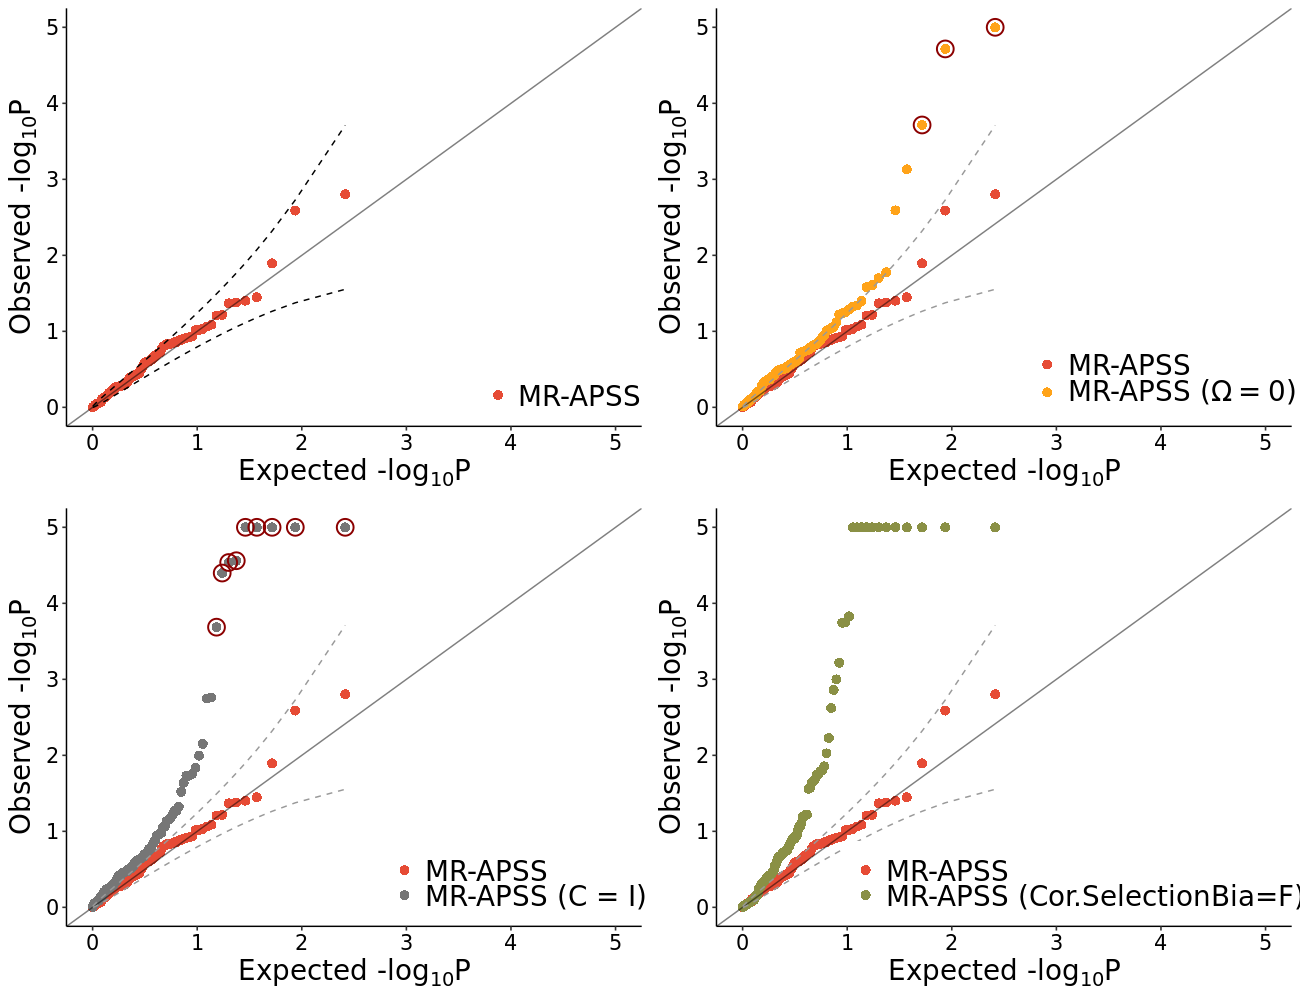

In [23]:
# Load packages
library(latex2exp)
library(gridExtra)
library(ggplot2)
library(ggpubr)

# Load QQ-plots functions
source('qqplot_funcs.R')

apss_res = read.table("NC_MRAPSS.MRres", header = F)
colnames(apss_res) = c("exposure","outcome", "nsnp","pi","nvalid","sigma.sq","tau.sq","b","se","pval",
                        "Method", "cor.Threshold", "IVstrength", "Threshold")

apss_res_dcast = na.omit(reshape2::dcast(unique(apss_res), exposure + outcome ~ Method, value.var = "pval", drop = T))

p1 = qqplot1(apss_res_dcast , "MR-APSS", max=5)+
  scale_color_manual(values = c("#E64B35FF"),
                     labels = list(TeX("MR-APSS"))) 

p2 = qqplot2(apss_res_dcast , "MR-APSS", "MR-APSS(Omega=0)", max=5) +
  scale_color_manual(values = c("#E64B35FF", "#FFA319FF"),
                     labels = list("MR-APSS", TeX("MR-APSS ($\\Omega = 0$)"))) 

p3 = qqplot2(apss_res_dcast , "MR-APSS", "MR-APSS(C=I)", max=5) +
  scale_color_manual(values = c("#E64B35FF", "#767676FF"),
                     labels = list("MR-APSS", "MR-APSS (C = I)")) 

p4 = qqplot2(apss_res_dcast , "MR-APSS", "MR-APSS(Cor.SelectionBia=F)", max=5, mark=F) +
  scale_color_manual(values = c("#E64B35FF", "#8A9045FF"),
                     labels = list("MR-APSS", "MR-APSS (Cor.SelectionBia=F)"))

options(repr.plot.width = 13, repr.plot.height = 10, repr.plot.res = 100)
grid.arrange(p1,p2,p3,p4, layout_matrix = matrix(c(1,2,3,4), ncol =2, byrow = T))
